#### 项目概要
- 此项目来源：github ***一根野猫猫***
- 此项目用途：复盘比赛时做的项目，***以备预推免的面试***
- 此项目的实现：大一时用MATLAB写的，***这里用Python复现一遍***
- 该项目的代码从第一问开始，我会将详尽的分析和注释写下，以记录我解决问题的详细思路。
- 此项目仅详细写一二问，因为第三问和第二问是完全一样的，第四问是语文建模，言之有理即可。



#### 研究了什么问题
生鲜商超自动定价和补货的问题，也就是通过供求关系来进行利益最大化的决策问题。如果从日常生活来说的话，可以理解为超市里的商品如何定价和补货的问题。
- 附件一是各种单品的分类信息，花叶类，瓜果类，茄子类里面分别有什么单品
- 附件二是交易的时间流水信息，有几十万条
- 附件三是每日商品的进货价格流水
- 附件四是各种单品的损耗率


#### 问题一解析
1. 两个主体，分别分析品类和品类之间的关系，以及单品和单品之间的关系。
2. 将附件一和附件二按照单品编码进行融合，再按照品类名称进行分组求和，得到了每个品类的总销量，画成饼状图得出不同品类商品的销售量占比
3. 将附件一和附件二按照单品编码进行表的融合，然后按照日期和品类进行分组求和，得到每天每个品类的总销量。转换为一个矩阵，行表示日期，列表示品类，值表示销量，每天都是一个样本。对这个矩阵进行JB检验，发现不满足正态性，于是采用斯皮尔曼相关系数分析各品类之间的相关性。
4. 单品同3，研究了单品之间的相关性
5. 将日期作为横坐标，品类日销量作为纵坐标画了一个销量时间图，有的商品销售规律与时间有关，是季节性的。
6. 基于肘部法则的k-means聚类分析，将品类分成畅销、一般、滞销

#### 项目结构
- 代码存放：根目录
- 数据存放：根目录下的data/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 数据可视化库
import statsmodels.api as sm  # Q-Q图 统计建模 回归分类
from scipy import stats  # 统计分析 统计检验工具  相关系数
from scipy.stats import linregress  # 拟合

from sklearn.cluster import KMeans  # 安装的包名是scikit-learn
from sklearn.preprocessing import StandardScaler

plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决字符乱码
plt.rcParams['axes.unicode_minus'] = False  # 解决负号乱码

这里将表一和表二进行融合，并计算每一个品类的总销量，然后据此画出饼状图。刻画了销量按品类的分布情况。

In [7]:
data1=pd.read_excel('附件1.xlsx')
data1
data2=pd.read_excel('附件2.xlsx')
data2

,销售日期,扫码销售时间,单品编码,销量(千克),销售单价(元/千克),销售类型,是否打折销售
0,2020-07-01,09:15:07.924,102900005117056,0.396,7.6,销售,否
1,2020-07-01,09:17:27.295,102900005115960,0.849,3.2,销售,否
2,2020-07-01,09:17:33.905,102900005117056,0.409,7.6,销售,否
3,2020-07-01,09:19:45.450,102900005115823,0.421,10.0,销售,否
4,2020-07-01,09:20:23.686,102900005115908,0.539,8.0,销售,否
...,...,...,...,...,...,...,...
878498,2023-06-30,21:35:13.264,102900005115250,0.284,24.0,销售,否
878499,2023-06-30,21:35:14.358,102900011022764,0.669,12.0,销售,否
878500,2023-06-30,21:35:20.264,102900005115250,0.125,24.0,销售,否
878501,2023-06-30,21:35:21.509,102900011016701,0.252,5.2,销售,否


In [10]:
import os  # 导入操作系统库，进行文件目录的管理
# 基于单品编码融合表1和表2并存储
merged_data_1_2 = pd.merge(data1, data2, left_on="单品编码", right_on="单品编码", how="outer")
output_path = 'data/merged_result_1_2.xlsx'
os.makedirs(os.path.dirname(output_path), exist_ok=True)  # 确保目录存在
merged_data_1_2.to_excel(output_path, index=False)  # 不保存索引列
merged_data_1_2


,单品编码,单品名称,分类编码,分类名称,销售日期,扫码销售时间,销量(千克),销售单价(元/千克),销售类型,是否打折销售
0,102900005115168,牛首生菜,1011010101,花叶类,2020-10-30,10:02:13.748,0.743,5.0,销售,否
1,102900005115168,牛首生菜,1011010101,花叶类,2020-10-30,10:48:42.707,0.502,5.0,销售,否
2,102900005115168,牛首生菜,1011010101,花叶类,2020-10-30,11:10:13.023,0.301,5.0,销售,否
3,102900005115168,牛首生菜,1011010101,花叶类,2020-10-30,12:34:32.084,0.382,5.0,销售,否
4,102900005115168,牛首生菜,1011010101,花叶类,2020-10-30,13:33:59.748,0.261,5.0,销售,否
...,...,...,...,...,...,...,...,...,...,...
878503,106973990980123,和丰阳光海鲜菇(包),1011010801,食用菌,2022-07-28,20:26:46.053,1.000,1.5,销售,是
878504,106973990980123,和丰阳光海鲜菇(包),1011010801,食用菌,2022-07-28,20:47:51.842,1.000,2.5,销售,否
878505,106973990980123,和丰阳光海鲜菇(包),1011010801,食用菌,2022-07-28,20:48:23.670,1.000,1.5,销售,是
878506,106973990980123,和丰阳光海鲜菇(包),1011010801,食用菌,2022-07-29,18:42:16.217,1.000,2.5,销售,否


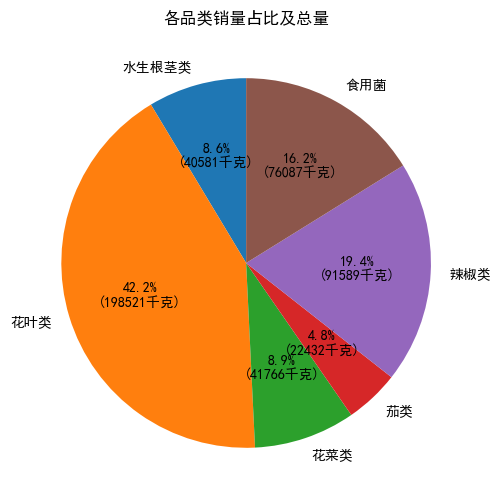

In [17]:
# 这里将merged_data_1_2按照品类分组然后按照销量进行求和。
category_sales_sum = merged_data_1_2.groupby('分类名称')['销量(千克)'].sum()
category_sales_sum
# 生成饼状图
# 生成饼图（显示百分比和总量）
plt.figure(figsize=(10, 6))
patches, texts, autotexts = plt.pie(
    category_sales_sum,
    labels=category_sales_sum.index,
    autopct=lambda p: f'{p:.1f}%\n({p/100*category_sales_sum.sum():.0f}千克)',
    startangle=90
)
plt.title('各品类销量占比及总量')
plt.show()


接下来将计算每个品类的日总销售，然后对销量进行正态分布的检验，以此确定使用皮尔逊还是斯皮尔曼相关系数进行相关性分析，再据此绘制热力图。

In [29]:
daily_mean = merged_data_1_2.groupby(['分类名称', '销售日期'])['销量(千克)'].sum().unstack(0)
from scipy.stats import jarque_bera

for col in daily_mean.columns:
    # 对每个品类的日销量数据计算 JB 统计量和 p 值
    jb_stat, p_value = jarque_bera(daily_mean[col].dropna())
    print(f"{col}: p值={p_value:.3f} ({'非正态' if p_value < 0.05 else '可能正态'})")



水生根茎类: p值=0.000 (非正态)
花叶类: p值=0.000 (非正态)
花菜类: p值=0.000 (非正态)
茄类: p值=0.000 (非正态)
辣椒类: p值=0.000 (非正态)
食用菌: p值=0.000 (非正态)


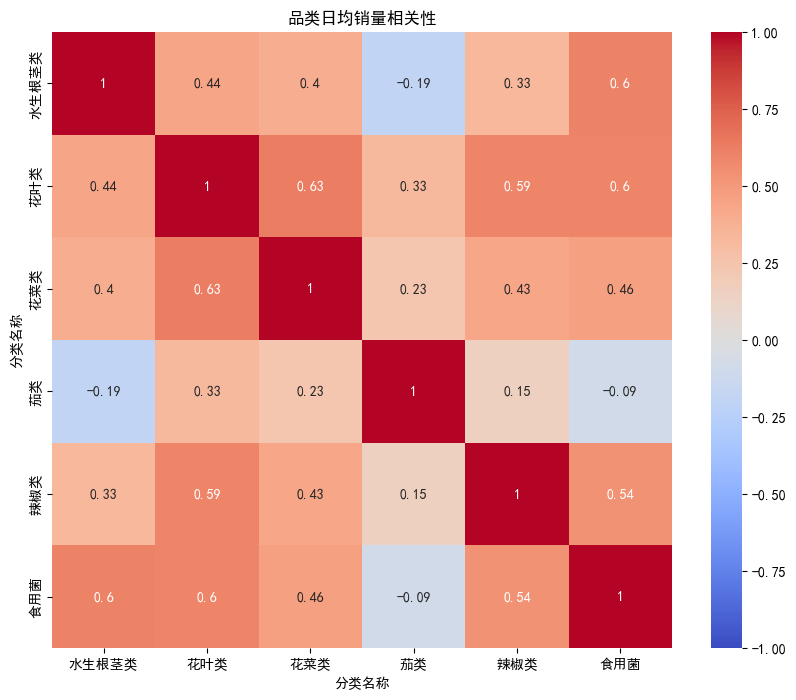

In [30]:
corr_method = 'spearman'  # 根据检验结果手动选择
corr_matrix = daily_mean.corr(method=corr_method)
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('品类日均销量相关性')
plt.show()

这里求单品之间的相关性，先求出单品的日总销量，再计算斯皮尔曼相关系数，再绘制热力图。

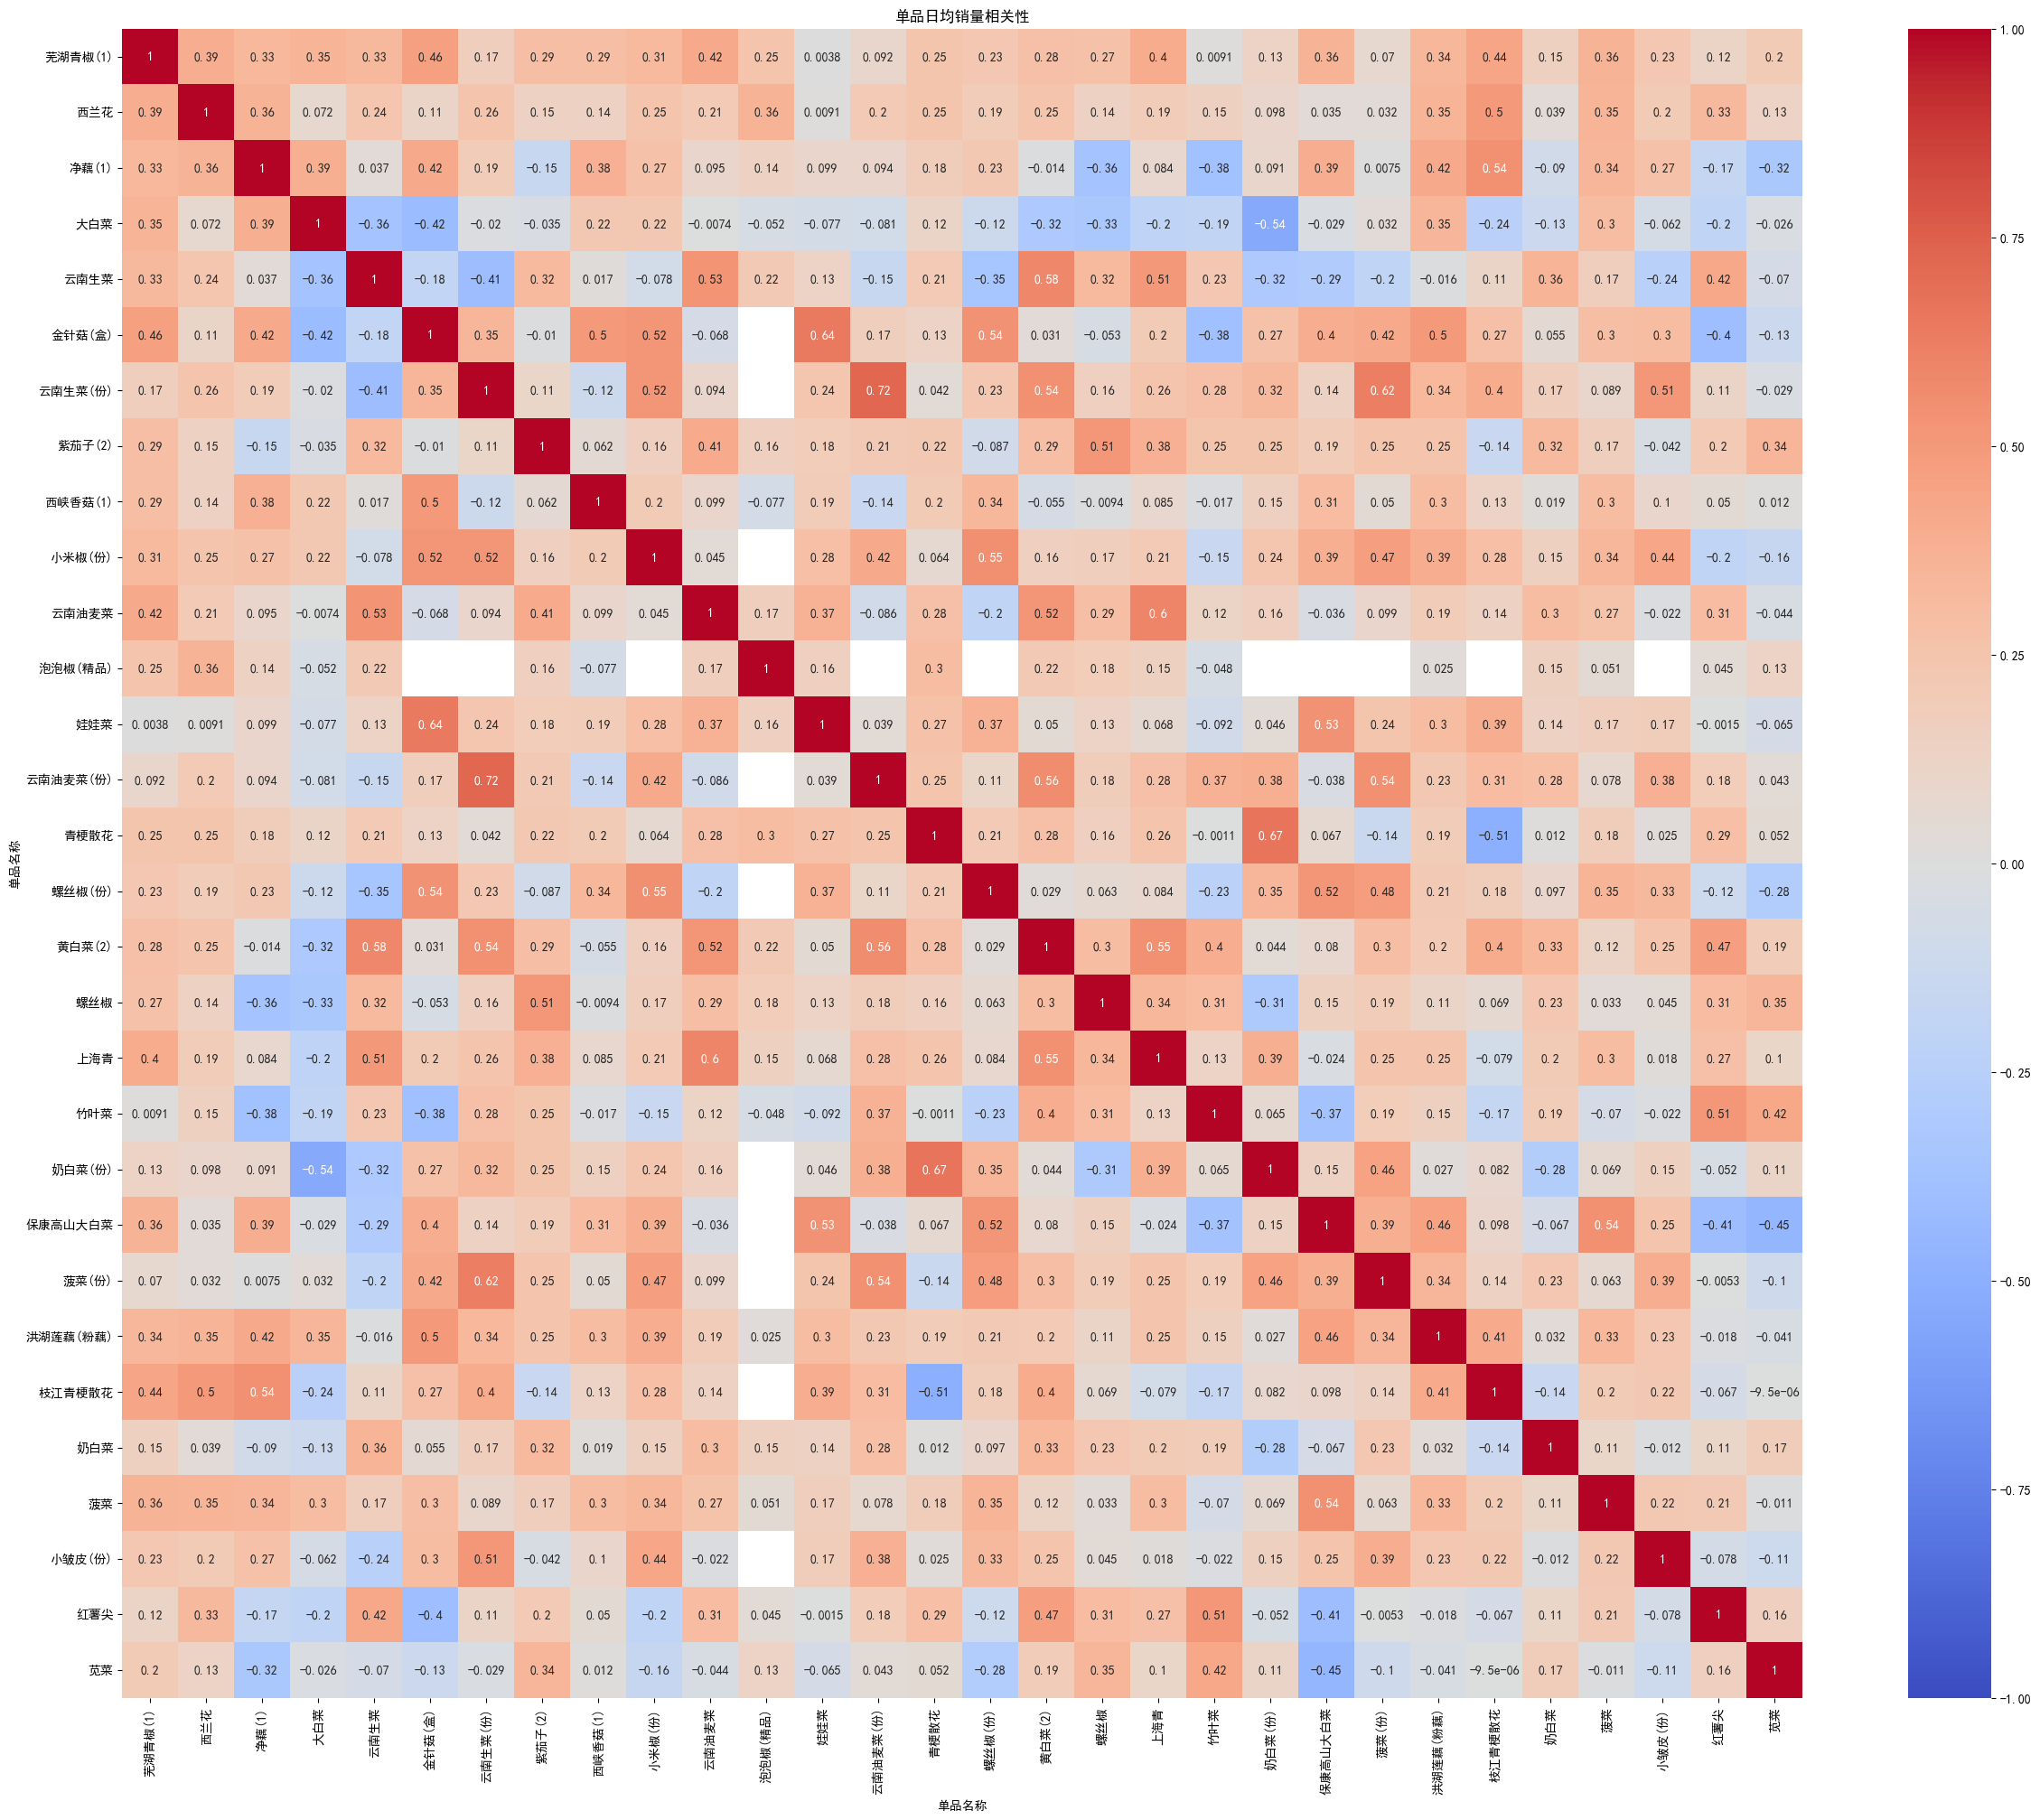

In [31]:
daily_item_sales = merged_data_1_2.groupby(['单品名称', '销售日期'])['销量(千克)'].sum().unstack(0)  # 单品编码转为列
# 计算每个单品总销量并取Top30
top30_items = merged_data_1_2.groupby('单品名称')['销量(千克)'].sum().nlargest(30).index

# 筛选Top30单品的日均销量数据
daily_top30 = daily_item_sales[top30_items]  # 直接从之前计算的daily_item_sales中提取
# 计算Top30单品相关性矩阵
corr_top30 = daily_top30.corr(method='spearman')
#  绘制热力图

plt.figure(figsize=(30,24))  # 图标的大小，和数字相对，防重叠。
sns.heatmap(corr_top30, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('单品日均销量相关性')
plt.show()


将日期作为横坐标，品类日总销量作为纵坐标画了一个销量时间图，有的商品销售规律与时间有关，是季节性的。

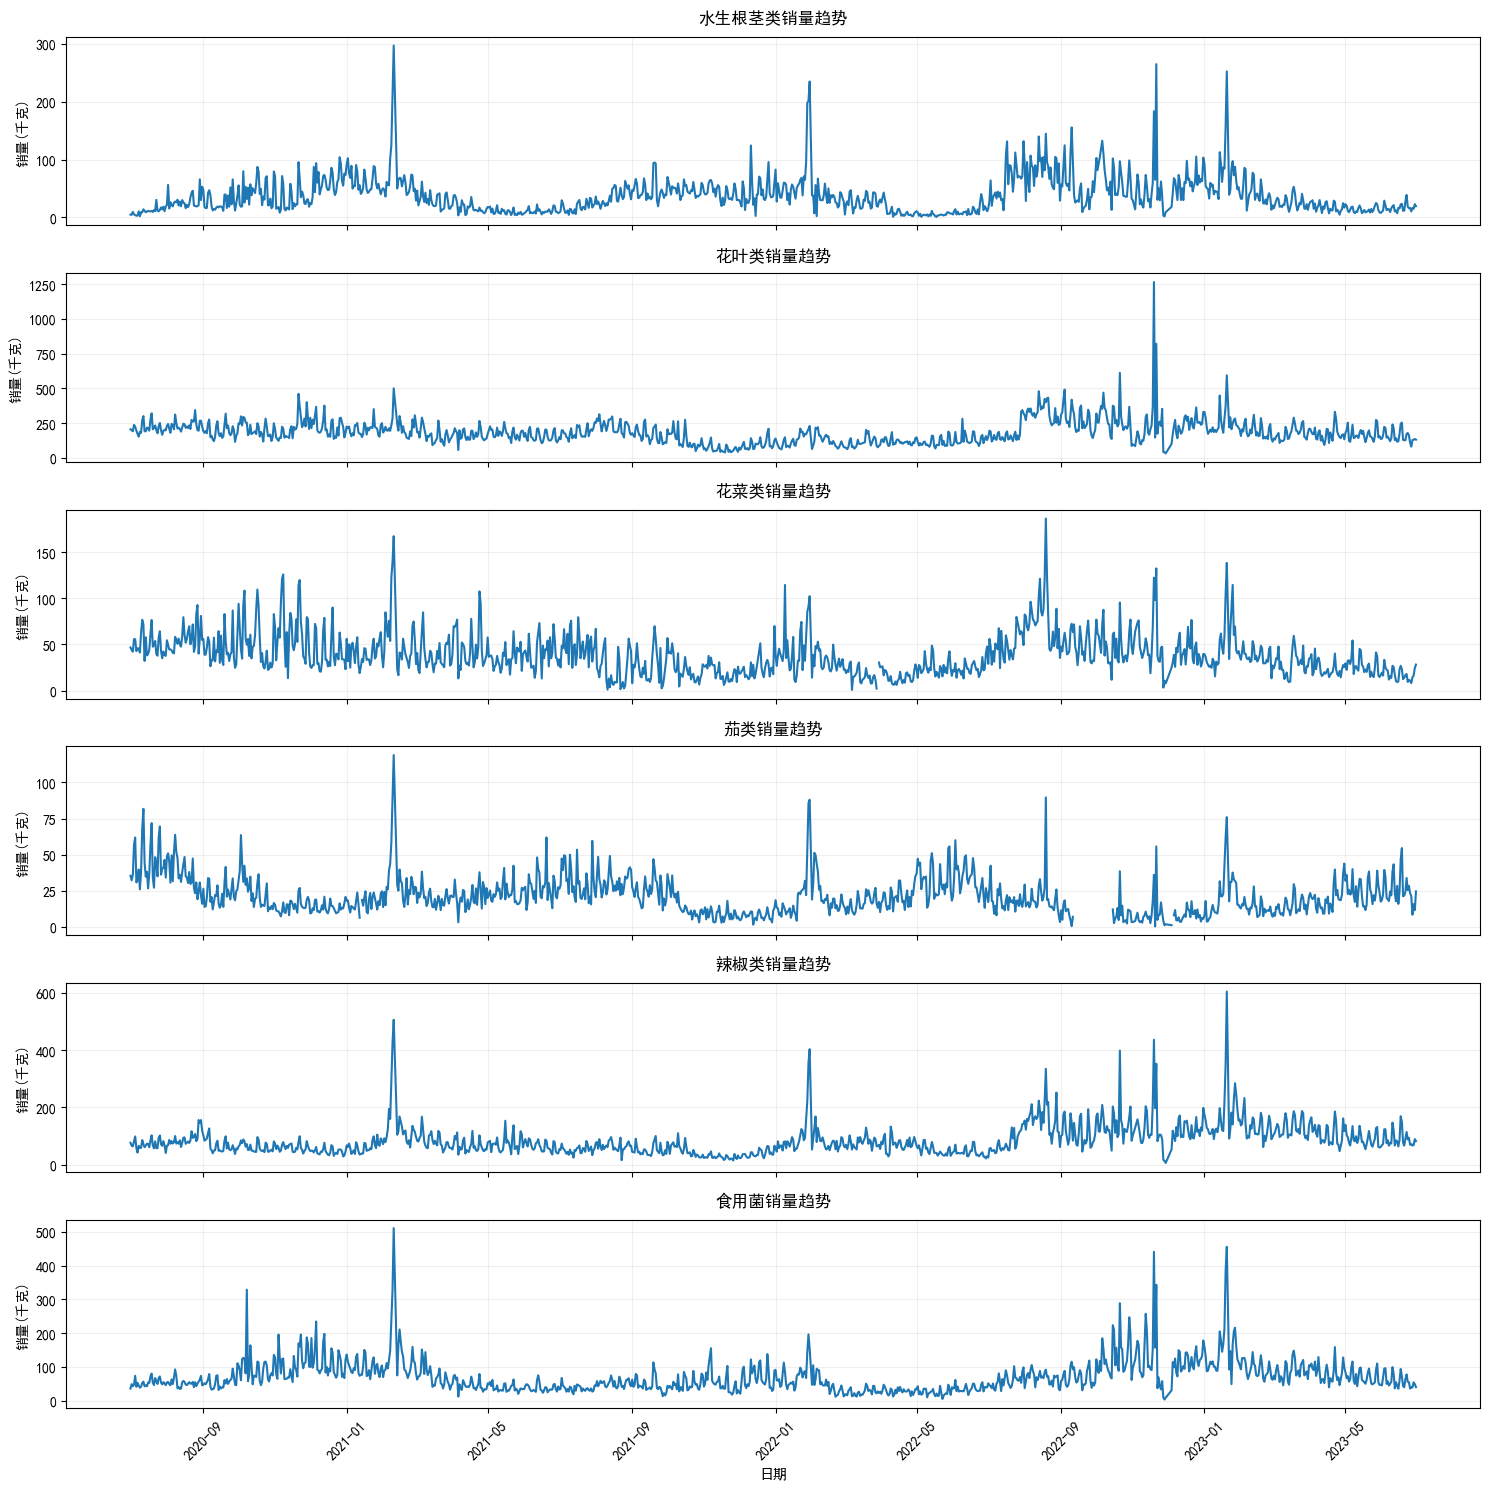

In [ ]:
# 获取所有品类名称
categories = daily_category_sales.columns

# 设置画布布局
fig, axes = plt.subplots(len(categories), 1, figsize=(15, 2.5*len(categories)))

# 为每个品类单独绘图
for i, category in enumerate(categories):
    ax = axes[i]
    ax.plot(daily_category_sales.index, 
            daily_category_sales[category],   # 从二维表格中读取每一列画图
            color='tab:blue', 
            linewidth=1.5)
    
    # 添加标题和标签
    ax.set_title(f'{category}销量趋势', fontsize=12, pad=10)
    ax.set_ylabel('销量(千克)', fontsize=10)
    ax.grid(alpha=0.2)
    
    # 隐藏重复的x轴标签（最后一张图保留）
    if i != len(categories)-1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('日期', fontsize=10)
        plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

基于肘部法则的k-means聚类分析，将品类分成畅销、一般、滞销

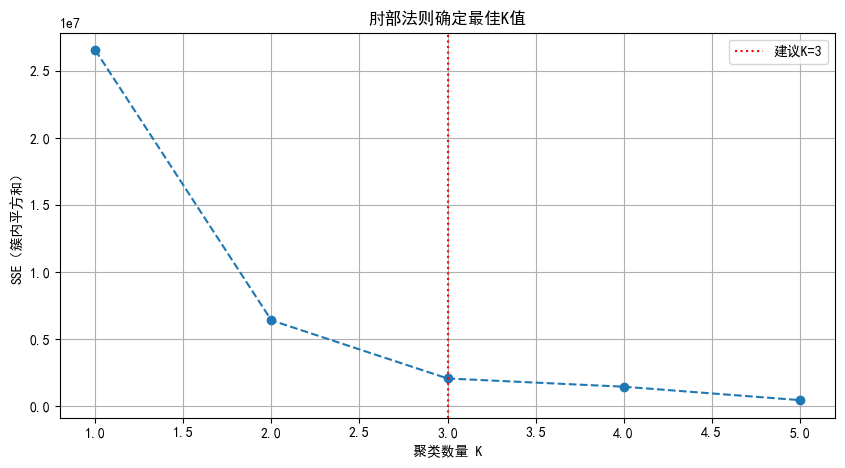

        分类名称 销售等级    日均销量
分类名称                     
花菜类      花菜类   滞销   38.49
水生根茎类  水生根茎类   滞销   37.40
茄类        茄类   滞销   20.67
花叶类      花叶类   一般  182.97
辣椒类      辣椒类   畅销   84.41
食用菌      食用菌   畅销   70.13

各类别销量描述统计：
      count        mean        std     min      25%     50%      75%     max
销售等级                                                                        
一般      1.0  182.970000        NaN  182.97  182.970  182.97  182.970  182.97
滞销      3.0   32.186667   9.988605   20.67   29.035   37.40   37.945   38.49
畅销      2.0   77.270000  10.097485   70.13   73.700   77.27   80.840   84.41


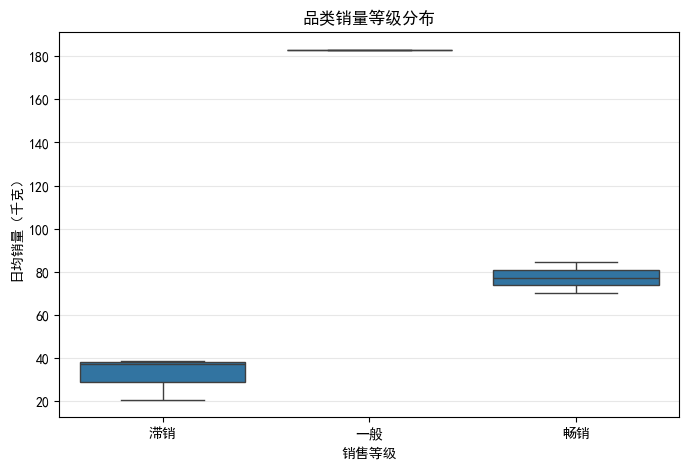

In [ ]:
# 计算每个品类的日均销量（行=日期，列=品类）
daily_category = merged_data_1_2.groupby(['分类名称', '销售日期'])['销量(千克)'].sum().unstack(0)

# 转置为行=品类，列=日期（每个品类是一个样本）
X = daily_category.T.fillna(0)  # 填充缺失值为0

from sklearn.cluster import KMeans

# 测试K值范围
inertia = []
for k in range(1, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# 绘制肘部曲线
plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), inertia, marker='o', linestyle='--')
plt.xlabel('聚类数量 K')
plt.ylabel('SSE（簇内平方和）')
plt.title('肘部法则确定最佳K值')
plt.axvline(x=3, color='r', linestyle=':', label='建议K=3')  # 标记建议分3类
plt.legend()
plt.grid()
plt.show()

# 正式聚类
kmeans = KMeans(n_clusters=3, random_state=42)
categories_cluster = kmeans.fit_predict(X)

# 将聚类结果映射到品类
cluster_result = pd.DataFrame({  # 按列组合
    '分类名称': X.index,
    '类别': categories_cluster,
    '日均销量': X.mean(axis=1).round(2)  # 计算每个品类的平均销量 并保留两位小数
})

# 按类别和销量排序
cluster_result = cluster_result.sort_values(['类别', '日均销量'], ascending=[True, False])

# 定义类别标签
cluster_labels = {0: '滞销', 1: '一般', 2: '畅销'}  # 通过字典进行聚类的映射
cluster_result['销售等级'] = cluster_result['类别'].map(cluster_labels)

# 打印结果
print(cluster_result[['分类名称', '销售等级', '日均销量']])

# 各类别统计量
print("\n各类别销量描述统计：")
print(cluster_result.groupby('销售等级')['日均销量'].describe())

# 绘制各类别销量分布箱线图
plt.figure(figsize=(8, 5))
sns.boxplot(data=cluster_result, x='销售等级', y='日均销量', order=['滞销', '一般', '畅销'])
plt.title('品类销量等级分布')
plt.ylabel('日均销量（千克）')
plt.grid(axis='y', alpha=0.3)
plt.show()